In [1]:
from fastai.metrics import accuracy
from fastai.optimizer import OptimWrapper
from fastai.vision.all import *
from PIL import Image

from torch import optim
import torch.nn as nn
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import AdamW
import cv2

import gc
import glob
import inspect
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from functools import partial

from skimage.metrics import structural_similarity as ssim
from skimage import color, transform
from sklearn.model_selection import StratifiedKFold

import warnings 
warnings.filterwarnings('ignore')
set_seed(3, reproducible=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
trn_path = '/kaggle/input/zindidata/images/images'
files    = get_image_files(trn_path) 

In [3]:
Train            = pd.read_csv('/kaggle/input/zindidata/Train.csv')
Test             = pd.read_csv('/kaggle/input/zindidata/Test.csv')
SampleSubmission = pd.read_csv('/kaggle/input/zindidata/SampleSubmission.csv')

In [4]:
damage = Train.damage.unique()

<Axes: xlabel='damage'>

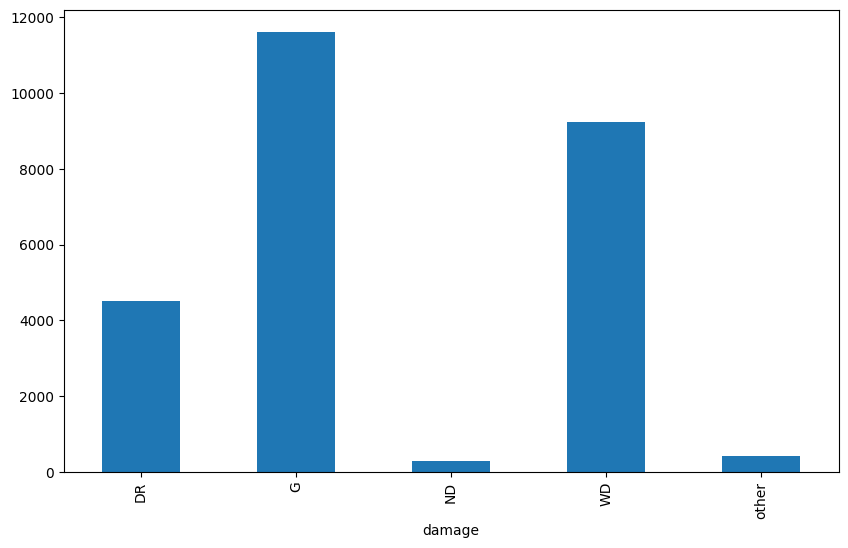

In [5]:
Train.groupby('damage').size().plot(kind='bar', figsize=(10, 6))

In [6]:
class_weights = torch.FloatTensor([1.3, 1.2, 1.1, 1.0, 2.8]).cuda()

In [9]:
IMG_HEIGHT = IMG_WIDTH = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
INCEPTION_MEAN = INCEPTION_STD = (0.5, 0.5, 0.5)


class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        
        return aug_img


def get_train_transforms(mean_std):
    augmentations = [
        A.VerticalFlip(p=.5),
        A.HorizontalFlip(p=.5),
        A.RandomRotate90(p=.5),
        A.ShiftScaleRotate(
            shift_limit=0.2, scale_limit=0.3, 
            rotate_limit=45, border_mode=0, p=.4
        ),
        A.RandomBrightnessContrast(brightness_limit=(-0.15,0.2), contrast_limit=(-0.1, 0.1), p=0.5),
        A.Cutout(
            max_h_size=int(IMG_HEIGHT*0.2),
            max_w_size=int(IMG_WIDTH*0.2),
            num_holes=4,
            p=.75,
        ),
    ]
    if mean_std=='imagenet':
        augmentations.append(A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD))
    elif mean_std=='inception':
        augmentations.append(A.Normalize(mean=INCEPTION_MEAN, std=INCEPTION_STD))
    else:
        augmentations.append(A.Normalize(mean=0, std=1))

    augmentations.append(ToTensorV2())
    return A.Compose(augmentations)


def get_valid_transforms(mean_std):
    augmentations = []
    if mean_std=='imagenet':
        augmentations.append(A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD))
    elif mean_std=='inception':
        augmentations.append(A.Normalize(mean=INCEPTION_MEAN, std=INCEPTION_STD))
    else:
        augmentations.append(A.Normalize(mean=0, std=1))

    augmentations.append(ToTensorV2())
    return A.Compose(augmentations)

def get_item_tfms(mean_std='imagenet'):
    return [Resize(224, method='squish'), AlbumentationsTransform(get_train_transforms(mean_std), get_valid_transforms(mean_std))]

In [10]:
class PrintLossCallback(Callback):
    def after_epoch(self):
        print(f"Epoch {self.epoch}: Validation loss = {self.validate()}")

In [11]:
def train(arch, item, batch, epoch=7):
    m_name = 'V'
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock(vocab=damage)),
                       get_x = ColReader('filename', pref = '/kaggle/input/zindidata/images/images/'),
                       get_y = ColReader('damage'),
                       splitter = RandomSplitter(valid_pct = 0.2, seed = 3),
                       item_tfms = item, #Resize(320, method = 'squish'),
                       batch_tfms = batch, #aug_transforms(size = 128, min_scale = 0.75)
                      )

    dls = dblock.dataloaders(Train, bs=98)
    learn = vision_learner(dls, arch, loss_func = CrossEntropyLossFlat(weight=class_weights), metrics=accuracy).to_fp16()
    learn.fine_tune(epoch, 0.018)  
    dls.rng.seed(3)
    interp = ClassificationInterpretation.from_learner(learn)
    losses,idxs = interp.top_losses()
    len(dls.valid_ds)==len(losses)==len(idxs)
    interp.plot_confusion_matrix(figsize=(7,7))
    interp.plot_top_losses(20)

    return learn

In [12]:
def free_memory(to_delete: list):
    calling_namespace = inspect.currentframe().f_back

    for _var in to_delete:
        calling_namespace.f_locals.pop(_var, None)
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
learn1 = train('convit_small.fb_in1k', get_item_tfms()
               , aug_transforms(min_scale= 0.75)
               , epoch=10)

model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.198707,0.932543,0.631306,07:25


epoch,train_loss,valid_loss,accuracy,time
0,0.882057,0.823661,0.688279,07:05
1,0.852475,0.802501,0.696720,07:14
2,0.847243,0.777661,0.708805,07:14
3,0.794700,0.877108,0.643967,07:11
4,0.756151,0.746055,0.727029,07:11
5,0.719509,0.725274,0.722233,07:14


In [ ]:
learn2 = train('convnext_small.in12k', get_item_tfms()
               , aug_transforms(min_scale= 0.75)
               , epoch=10)

In [ ]:
learn3 = train('deit_small_distilled_patch16_224.fb_in1k', get_item_tfms()
               , aug_transforms(min_scale= 0.75)
               , epoch=10)

In [ ]:
valid = learn1.dls.valid
preds1 , targets = learn1.tta(dl=valid)
accuracy(preds1 , targets)

In [ ]:
preds1 = F.softmax(preds1, dim=1)
preds1

In [ ]:
valid = learn2.dls.valid
preds2 , targets = learn2.tta(dl=valid)
accuracy(preds2 , targets)

In [ ]:
preds2 = F.softmax(preds2, dim=1)
preds2

In [ ]:
valid = learn3.dls.valid
preds3 , targets = learn3.tta(dl=valid)
accuracy(preds3 , targets)

In [ ]:
preds3 = F.softmax(preds3, dim=1)
preds3

In [ ]:
ensemble_preds = (preds1 + preds2 + preds3) / 3
accuracy(ensemble_preds , targets)

In [ ]:
ensemble_preds

In [ ]:
test_dl = learn1.dls.test_dl('/kaggle/input/zindidata/images/images/' + Test['filename'])
preds1 , _ = learn1.tta(dl=test_dl)

In [ ]:
preds1 = F.softmax(preds1, dim=1)

In [ ]:
submission_sf = pd.DataFrame({
    
    'ID': Test['ID'],
    'DR': preds1[:, 0].squeeze().numpy(),
    'G' : preds1[:, 1].squeeze().numpy(),
    'ND': preds1[:, 2].squeeze().numpy(),
    'WD': preds1[:, 3].squeeze().numpy(),
    'other': preds1[:, 4].squeeze().numpy(),
})
submission_sf.to_csv('convit5.csv', index=False)

In [ ]:
submission_sf

In [ ]:
test_dl = learn2.dls.test_dl('/kaggle/input/zindidata/images/images/' + Test['filename'])
preds2 , _ = learn2.tta(dl=test_dl)

In [ ]:
preds2 = F.softmax(preds2, dim=1)

In [ ]:
submission_sf = pd.DataFrame({
    
    'ID': Test['ID'],
    'DR': preds2[:, 0].squeeze().numpy(),
    'G' : preds2[:, 1].squeeze().numpy(),
    'ND': preds2[:, 2].squeeze().numpy(),
    'WD': preds2[:, 3].squeeze().numpy(),
    'other': preds2[:, 4].squeeze().numpy(),
})
submission_sf.to_csv('convnext5.csv', index=False)

submission_sf

In [ ]:
test_dl = learn3.dls.test_dl('/kaggle/input/zindidata/images/images/' + Test['filename'])
preds3 , _ = learn3.tta(dl=test_dl)

In [ ]:
preds3 = F.softmax(preds3, dim=1)

In [ ]:
submission_sf = pd.DataFrame({
    
    'ID': Test['ID'],
    'DR': preds3[:, 0].squeeze().numpy(),
    'G' : preds3[:, 1].squeeze().numpy(),
    'ND': preds3[:, 2].squeeze().numpy(),
    'WD': preds3[:, 3].squeeze().numpy(),
    'other': preds3[:, 4].squeeze().numpy(),
})
submission_sf.to_csv('deit_small5.csv', index=False)

In [ ]:
submission_sf

In [ ]:
ens_preds = (preds1 + preds2 + preds3) / 3

In [ ]:
submission_sf = pd.DataFrame({
    'ID': Test['ID'],
    'DR': ens_preds[:, 0].squeeze().numpy(),
    'G' : ens_preds[:, 1].squeeze().numpy(),
    'ND': ens_preds[:, 2].squeeze().numpy(),
    'WD': ens_preds[:, 3].squeeze().numpy(),
    'other': ens_preds[:, 4].squeeze().numpy(),
})
submission_sf.to_csv('ens5.csv', index=False)